# FREESPACE SEGMENTATION WITH PYTORCH

This project's purpose is finding the driveable area (or otherwise freespace) in the high way road. Which is quite a large subject when thinking of the high way's elements.Like lines, debris, barriers, etc. Although this is not the general subject, in the below sections dashed line, solid line, and traffic sign models added to the project.
<br>
Codes left in the files but important ones are explained and exampled, also files can be visible in the repository.
<br>
This project developed on Windows 10 with Anaconda (python3) and CUDA available graphic card.
<br>
To see the project process, steps are explained below:
<div>
    <ul>
        <li>JSON to Mask: "Freespace" (as class title) searched in the JSON files. After that, pattern drawn to the empty mask as 0 1 type</li>
        <li>Preprocess: Masks and images converted to the tensors. One difference between image and mask tensor is the one hot encode for the mask.</li>
        <li>Model: For the project, the UNet model was selected(according to preference).</li>
        <li>Train: Dataset separated 3 parts to train, validation, and test. The predictions of the model are taken in this section. </li>
        <li>Dashed Line, Solid Line Segmentation</li>
    </ul>
</div>


## JSON to Mask

JSON files contain lots of content about the annotated image like class titles, points of objects, height and width of the image, etc. Firstly all of the JSON files must be loaded and then should be open in order. For the pattern of mask,freespace needed to found. Once freespace found, a pattern must be drawn an empty mask as 0 1 type.1 is represent the freespace, and 0 present the other pixels.

These libraries need to be imported for this part:
<ul>
    <li>import numpy as np</li>
    <li>import cv2</li>
    <li>import json</li>
    <li>import os</li>
    <li>from os import listdir</li>
    <li>from os.path import isfile,join</li>
</ul>

To load the JSON files, the path of their folder and images folder must be defined.JSON files can be added to the list with the following code:

In [ ]:
file_names=[f for f in listdir(mypath) if isfile(join(mypath, f))]

To open JSON files in order and found freespace, for loop used. Also, files are loaded for use.

In [ ]:
for i in range(len(file_names)):
    fileopen=open(mypath+"\\"+file_names[i]) 

    json_dict = json.load(fileopen)

The mask of the picture must be the same size as the picture, so width and height were taken from the JSON file.

In [ ]:
h_image=json_dict['size']['height']
w_image=json_dict['size']['width']

Creating a mask started by creating an empty mask with the help of the NumPy library.

In [ ]:
mask=np.zeros((h_image,w_image),dtype= np.uint8)

Thus, the outline of the freespace is created. Points of the freespace are needed to create the pattern.

In [ ]:
json_objs=json_dict["objects"]  
for obj in json_objs:
        class_name=obj['classTitle'] #freespace required
        if class_name == "Freespace" :
            p=obj['points']          
            freespace_points=p['exterior'] #freespace's points x,y type

Everything is set up to create the pattern.0 for the other pixels and 1 for the freespace.

In [ ]:
image=cv2.fillPoly(mask,np.array([freespace_points]),1)

After saving .png file, mask may appear full black, but when written as an array, 0s and 1s can be seen. To check the result, a mask can be drawn on its image with following code:

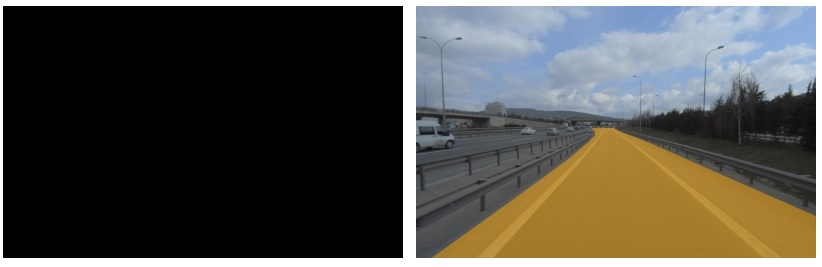

In [ ]:
mask  = cv2.cv2.imread(mask_path, 0).astype(np.uint8)
image = cv2.cv2.imread(image_path).astype(np.uint8)

mask_ind   = mask == 1
cpy_image  = image.copy()
image[mask==1,:] = (0, 165, 255)
opac_image = (image/2 + cpy_image/2).astype(np.uint8)

This code's progress is to read the mask and image as uint8 type after that find the numbers in mask equal to 1 which is freespace representation after that color them with color code (0,165,255) on the image.
<br>
Dividing image and cpy_image to 2, gives us a colored part on the image.

<br>
<br>

## Preprocess

Images and masks must be tensor to train the model. But there is one difference between converting the mask and image to tensor. It's one hot encoding. Masks are drawn 0 and 1 type before. The function of one-hot encoding is label 1s as freespaces for the computer.

During the tensor function, both of them (image and mask) are resized for the standard input. Images are RGB (3 channel) and masks are GrayScale (2 channel) type.

<b>Note that: CUDA usage makes these processes faster.</b>

Resize the image to the output size.

In [ ]:
image = cv2.resize(image, output_shape)

Convert the image_list to the NumPy array and after that convert the NumPy list to the tensor.

In [ ]:
image_array = np.array(image_list, dtype=np.float32)
torch_image = torch.from_numpy(image_array).float()

To determine the CUDA usage following code needed to add.

In [ ]:
 if cuda:
        torch_image = torch_image.cuda()
    return torch_image

Image tensors are in [batch_size, output_shape[0], output_shape[1], 3] shape.

These steps are applied to the mask as well. After the resize mask following code applied.

In [ ]:
mask = one_hot_encoder(mask, n_class)

In [ ]:
def one_hot_encoder(data, n_class):
    encoded_data = np.zeros((*data.shape, n_class), dtype=np.int)
    encoded_labels = [[0,1], [1,0]]
    for lbl in range(n_class):
        encoded_label = encoded_labels[lbl]
        numerical_class_inds = data[:,:] == lbl
        encoded_data[numerical_class_inds] = encoded_label
    return encoded_data

As written earlier freespaces(1s as according to preference) are labeled in order. Function returns encoded data.
<br>
After masks converted to tensor,tensor shape is [batch_size, output_shape[0], output_shape[1], 2]. 2 for the grayscale image.

<br>
<br>

## Model
<br>
<br>

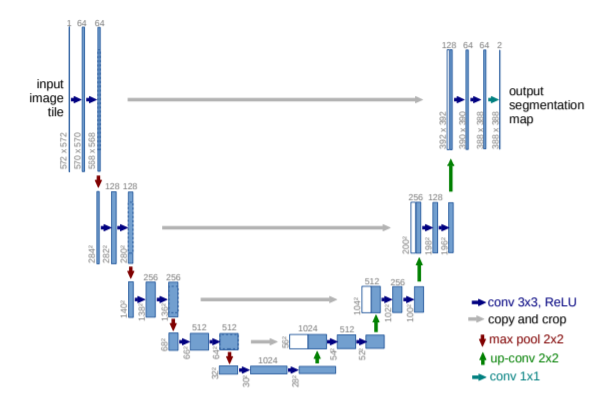

<p style="text-align:center;">image source[5](from unet paper)</p>

UNet contains two parts. One part is downsampling, then the resolution of the picture increases with upsampling. Max-pooling and ReLu were used in the downsampling part of UNet.And the upsampling part bilinear interpolation used in the upsample function.

<b>Activation Function:</b>Simply put, an activation function is a function that is added into an artificial neural network in order to help the network learn complex patterns in the data. When comparing with a neuron-based model that is in our brains, the activation function is at the end deciding what is to be fired to the next neuron.[4]

The most commonly known activation functions: Softmax, Relu, Leaky ReLu, and Sigmoid function.
<br>
ReLu activation function used in this model.

<b>ReLu:</b>ReLu is a non-linear activation function that is used in multi-layer neural networks or deep neural networks.
<br>
This function can be represented as: f(x) =max(0,x)
<br>
According to equation 1, the output of ReLu is the maximum value between zero and the input value. The output is equal to zero when the input value is negative and the input value when the input is positive.[1]
<br>
<b>graph source[2]</b>

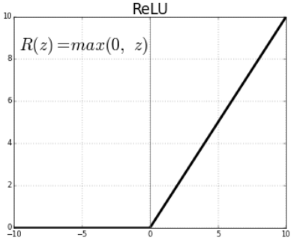

<b>Kernel:</b> Applied filter mask.
<br>
<b>Stride:</b> The number of steps.
<br>
<b>Maxpooling:</b>The largest pixel in that area is selected according to the kernel size.Complexity is reduced by keeping height and width information constant.Below image kernel_size=2 with stride=2.

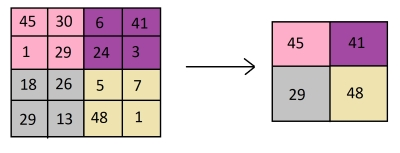

If the kernel size does not divide the picture exactly, padding can be applied.Padding adds extra pixels around the image and prevents displacement.Also stride can be changeable according to the project.In the following image padding=1 applied.

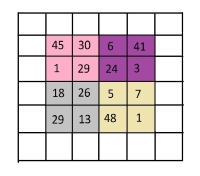

<b>Upsampling:</b>Upsample puts new values between the original pixels to increase the image size. While adding pixels, upsampling uses functions. This model contains the bilinear interpolation.

<b>Bilinear Interpolation:</b>Bilinear interpolation is a technique for calculating values of a grid location-based on nearby grid cells. The key difference is that it uses the FOUR closest cell centers.
Using the four nearest neighboring cells, bilinear interpolation assigns the output cell value by taking the weighted average. It applies weights based on the distance of the four nearest cell centers smoothing the output raster grid.[3]

<b>torch.cat() function:</b>Concatenates the given sequence of seq tensors in the given dimension. All tensors must either have the same shape (except in the concatenating dimension) or be empty.[6]

<b>conv2d function:</b>Applies a 2D convolution over an input signal composed of several input planes.[7]

After the model has been fully considered, codes added below(for full view model.py):

In [ ]:
def m_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )   

In [ ]:
self.down1 = m_conv(3, 64)
        self.down2 = m_conv(64, 128)
        self.down3 = m_conv(128, 256)
        self.down4 = m_conv(256, 512)

In [ ]:
self.maxpooling = nn.MaxPool2d(2)
self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

In [ ]:
self.up3 = m_conv(256 + 512, 256)
self.up2 = m_conv(128 + 256, 128)
self.up1 = m_conv(128 + 64, 64)

self.last = nn.Conv2d(64, n_classes, 1)

In [ ]:
def forward(self, x):
        conv1 = self.down1(x)
        x = self.maxpooling(conv1)

        conv2 = self.down2(x)
        x = self.maxpooling(conv2)

        conv3 = self.down3(x)
        x = self.maxpooling(conv3)

        x = self.down4(x)

        x = self.upsample(x)
        x = torch.cat([x, conv3], dim=1)

        x = self.up3(x)
        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)

        x = self.up2(x)
        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)

        x = self.up1(x)

        out_layer = self.last(x)
        return out_layer

<br>
<br>

## Train

Multiple different metrics were evaluated while training the model. The model with the best result (with the least loss) was selected as the main model and the results from the evaluations are added below.

The loss function given in the script was giving an error, so MSE loss was used instead.Both(script and other selected) optimizers have applied the model with the same epoch number for the comparison.

Train, validation, and test data are not separated in Dataset.
First of all, the data is separated by percentage.In this part, normalization can be applied to the data according to preference.
<br>
The values valid in the project should be defined.

In [ ]:
valid_size = 0.3
test_size  = 0.1
batch_size = 4
epochs = 20 #this will change during the project for the evaluation
cuda = True
input_shape = (224, 224)
n_classes = 2

Path of mask and images are defined and files in folders are uploaded. Since all definitions are made, dataset separation can be made with the following code.

In [ ]:
# SLICE TEST DATASET FROM THE WHOLE DATASET
test_input_path_list = image_path_list[:test_ind]
test_label_path_list = mask_path_list[:test_ind]



# SLICE VALID DATASET FROM THE WHOLE DATASET
valid_input_path_list = image_path_list[test_ind:valid_ind]
valid_label_path_list = mask_path_list[test_ind:valid_ind]



# SLICE TRAIN DATASET FROM THE WHOLE DATASET
train_input_path_list = image_path_list[valid_ind:]
train_label_path_list = mask_path_list[valid_ind:]


Model call and optimizer, loss definition was made.

In [ ]:
# CALL MODEL
model = FoInternNet(n_classes=2)

# DEFINE LOSS FUNCTION AND OPTIMIZER
criterion =  nn.MSELoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)


CUDA usage checked.

In [ ]:
# IF CUDA IS USED, IMPORT THE MODEL INTO CUDA
if cuda:
    model = model.cuda()

The entire train part can be seen in the train.py file.
<br>
Test data allocated to get the model prediction.

In [ ]:
for img in test_input_path_list:
    shutil.copy(image_test,'..\\folder')
for msk in test_label_path_list:
    shutil.copy(mask_test,'..\\folder') 

The trained model was saved.

In [ ]:
PATH='..\\model_name.pt'
torch.save(model,PATH)

The code used to draw the graphs:

In [ ]:
normalized_training= [float(i)/max(traning_loss_list) for i in traning_loss_list]
normalized_validation=[float(j)/max(validation_loss_list) for j in validation_loss_list]
plt.plot(normalized_training,label='training loss list')
plt.plot(normalized_validation,label='validation loss list')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

To choose the optimizer, model trained with 5 epoch Adam optimizer and SGD optimizer. It was a quick look at the loss change.
According to the results, it was more correct to use Adam optimizer for the UNet model.

Likely MSE Loss function + Adam optimizer looked the best option. After the functions are decided, different epoch numbers are tried on the model.
<br>
At the left, the model trained with 10 epoch(every epoch takes about 716 images), and at the right epoch number is 20.

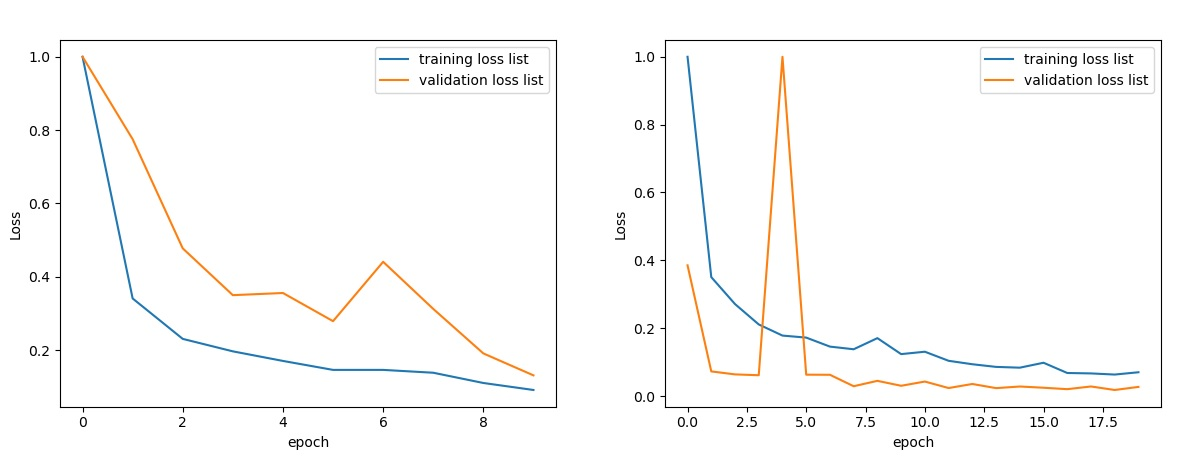

The reason why validation error is less than training error in the Epoch 20 graph maybe that training data is easier than validation data.The desired graphic is that the validation loss is slightly more than the training loss.

Outputs of the model(unnormalized) directly converted from tensor to image with the following code:

In [ ]:
torchvision.utils.save_image(output,path)

The model was then uploaded and predicted on the test data. While evaluating, eval() was used to disable layers such as Batch Normalization and Dropout.

In [ ]:
model=torch.load(model_path)
model.eval()

The data given to the model must be tensor, so the tensorize_image function used in the preprocessing stage should be used. Afterward, prediction can be taken from the model.

In [ ]:
output=model(tesorized_test_data)

Model predictions according to the number of epoch without making any changes to the data are given as 10 epoch 20 epoch and the ground truth, respectively.


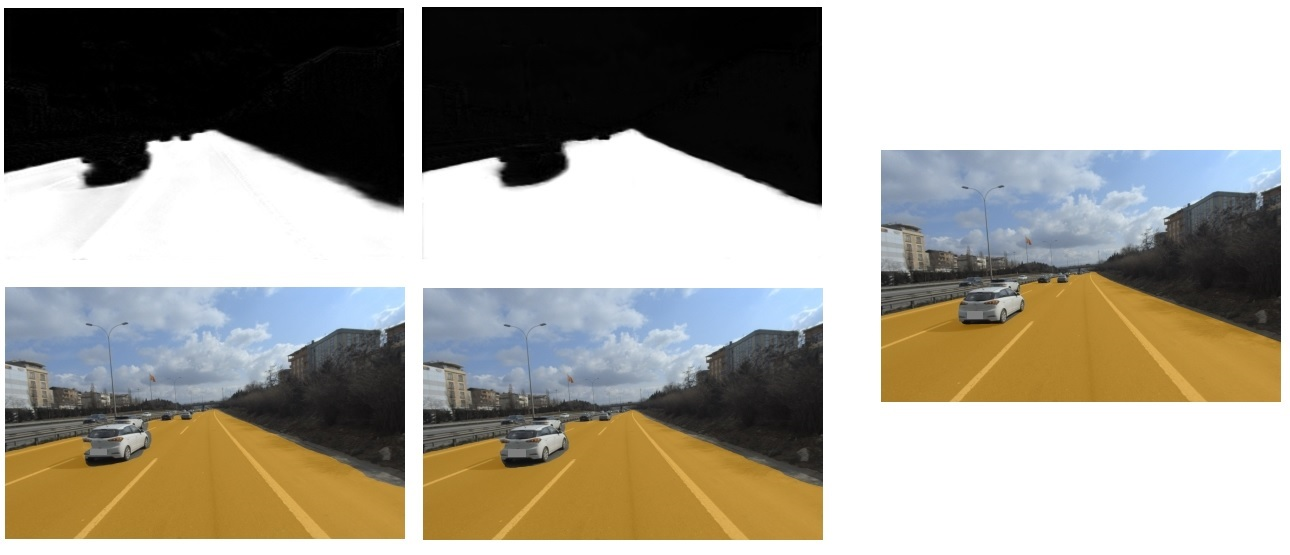

In the 10 epoch, the model mostly made the wrong prediction around the car. In the 20 epoch, the model mostly caught the right prediction around the car but still, some wrong predictions were there.

In such a case, increasing the number of epochs seems like a good choice. But if the loss of the validation increases, the model starts to memorize it. When the model memorizes the pictures, it makes false predictions in the test data (has never seen). Dropout or augmentation can be used to prevent the model from overfitting.

It is important to examine situations that are not usually encountered on the road, such as viaducts and tunnels that may confuse the prediction of the model, to reach a correct working model.

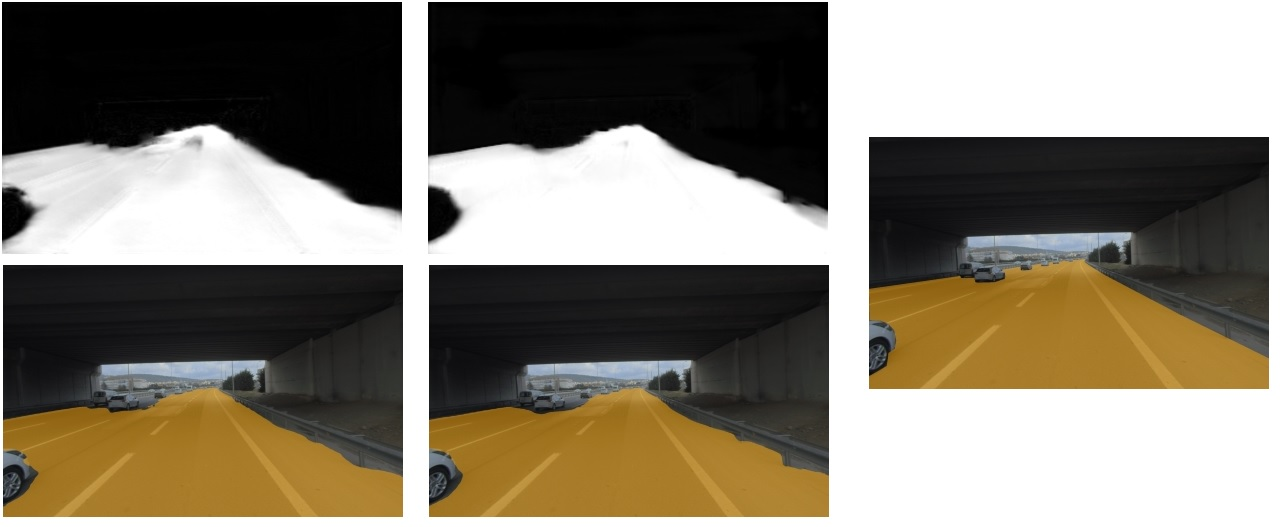

The model behaved consistently in changing lights and did not perceive the viaduct as freespace, but made incorrect predictions, especially around the vehicles and freespace's road border.

Below is the examination of the tunnels where the light is diminished, which will make the model's prediction much more difficult.

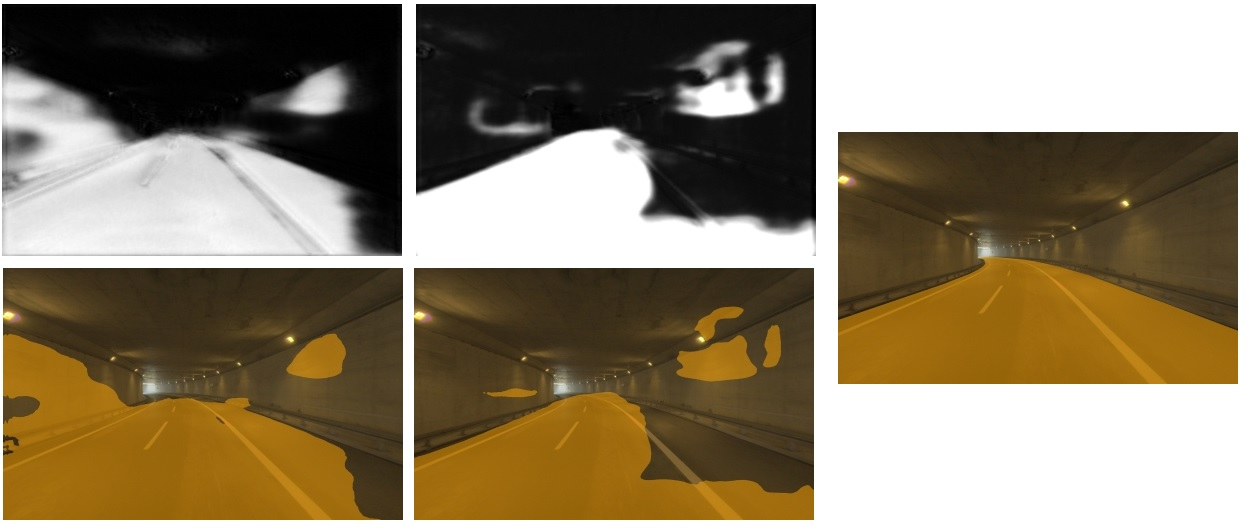

The model also perceived the walls of the tunnel as freespaces due to the light changes. As the training time increased, the freespaces on the wall decreased. However, it is not the desired prediction.

It is necessary to look at the counters to see how the model predicts when the light is normal but the elements on the road are excessive.

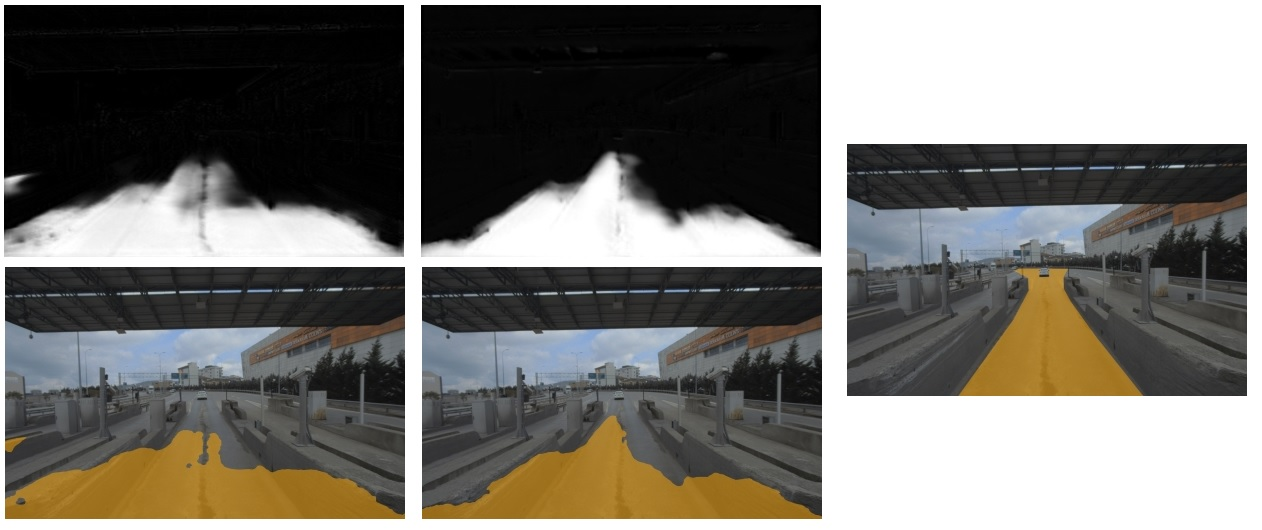

The prediction of the model on the counters seems wrong due to the color of the concrete barriers.
Although the freespace selected area decreases as the number of epochs increases, the model's prediction is far from expected.

Long vehicles such as trucks and trailers can present a situation similar to tunnel walls, causing confusion in the model's prediction.

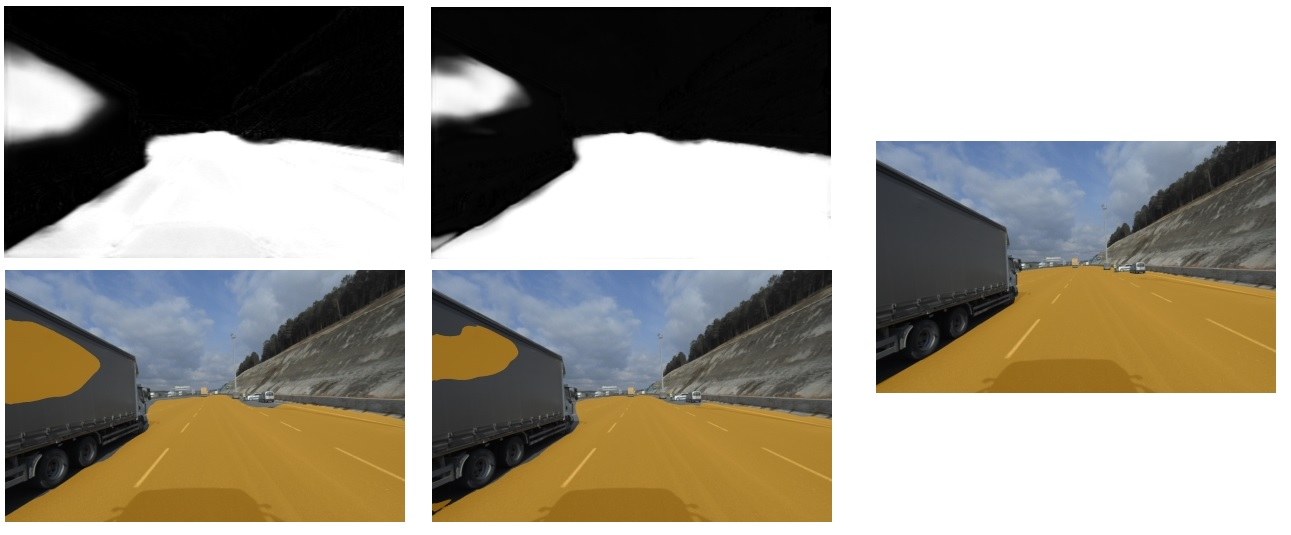

The model perceived the truck as freespace but that was a wrong prediction. Even increasing the number of epoch couldn't solve the wrong prediction. Augmentation can handle this and similar situations.

The dataset of the project is not enough for the model to make accurate predictions in light changes or different situations. In such a case, augmentation can be applied to the dataset.
<br>
<b>Data Augmentation:</b> Data augmentation is a technique for modifying the data used in the project. It has options such as adding noise, changing images angle, rotating or changing images contrast. Mirroring, one of the most basic technique, was applied to the dataset for this project.

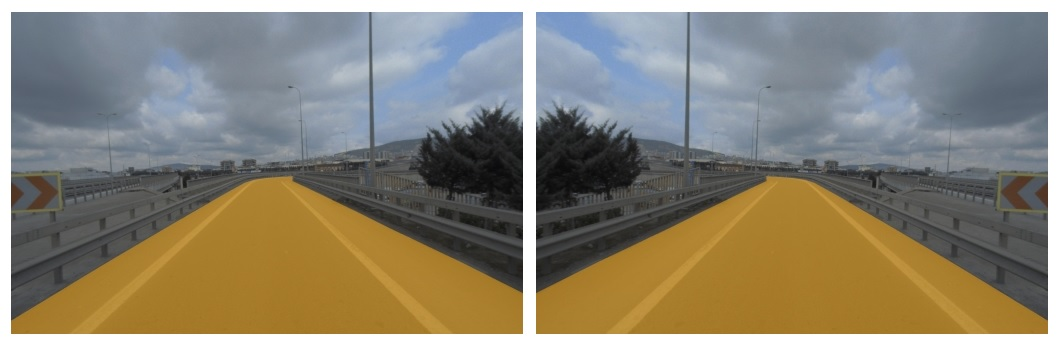

Data augmentation does not have to be applied to the whole data, can be applied only to selected ones, but it must also be applied to the mask of that image. Increasing the number of pictures for training, normally increases the training time. This technique also prevents the model from being overfitted.

Below is a comparison of the losses of the models in the same number of epochs. (Epoch 20,adam optimizer and MSE Loss function)
<br>
On the left-side graph before augmentation and the right-side graph after augmentation.

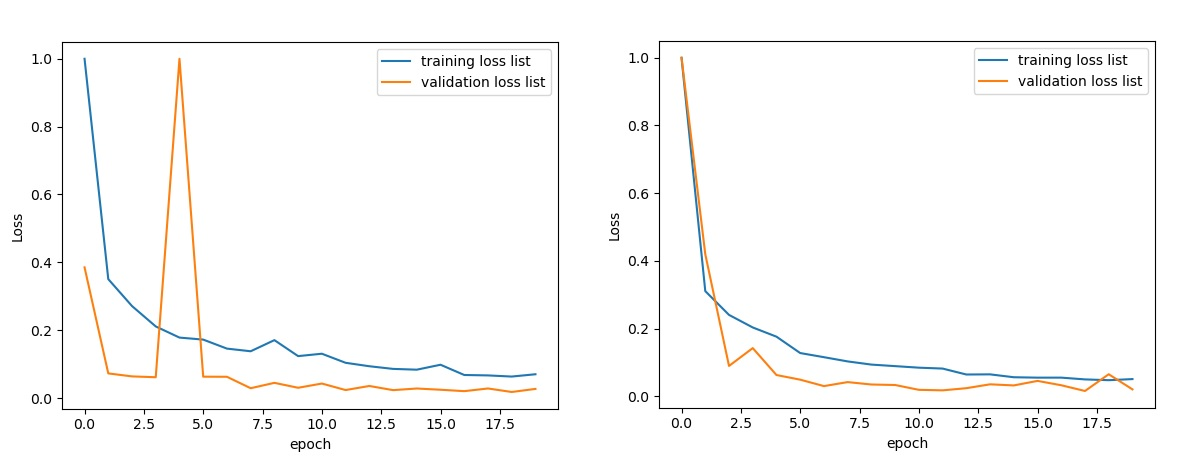

In the model's validation loss has peak before the augmentation and augmentation prevent that in the validation loss.

Currently, the predictions of the model are expected to be closer to the ground truth than the previous ones. Comparing with other situations and seeing what kind of changes will be beneficial in terms of how to follow the training process.

The top picture is the ground truth, and the model's prediction left to right is epoch 10 epoch 20 and after augmentation epoch 20.

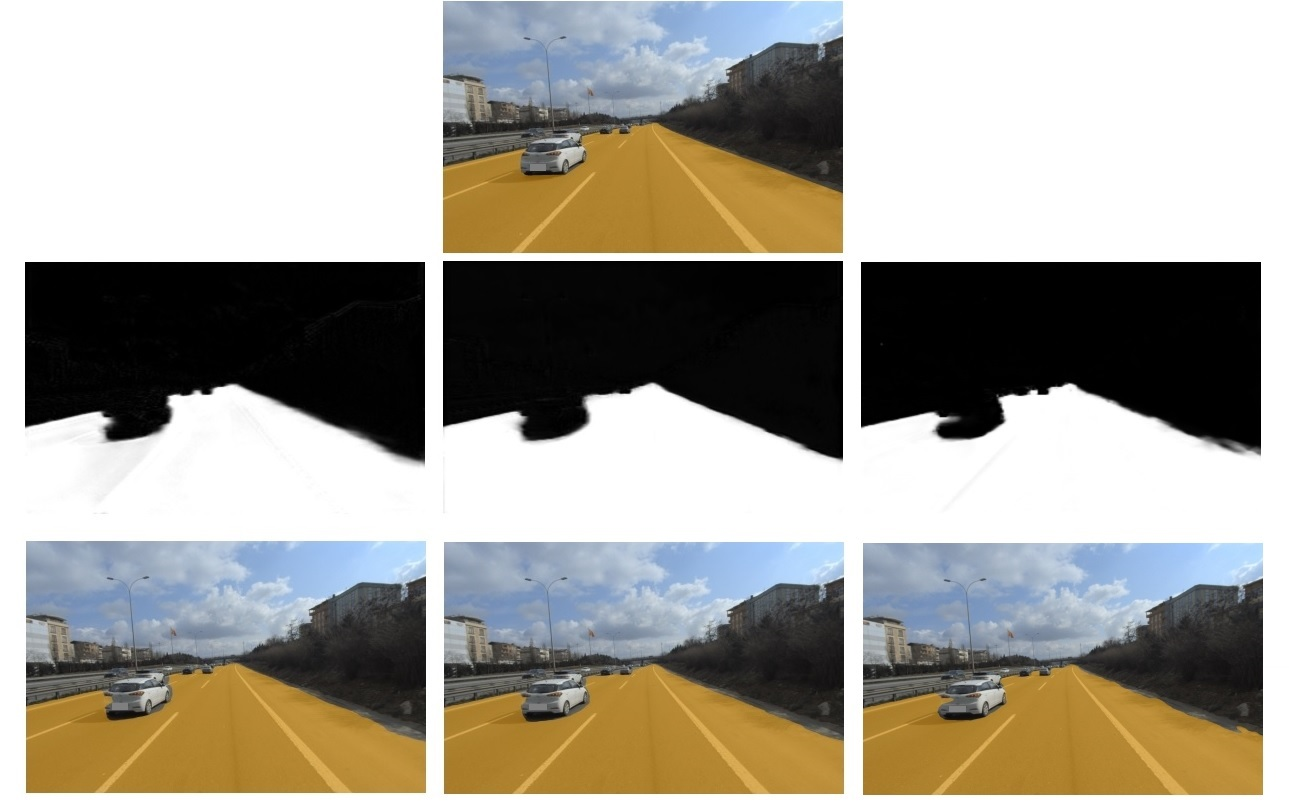

Augmentation did not provide the full benefit, rather it caused distortions in close range.

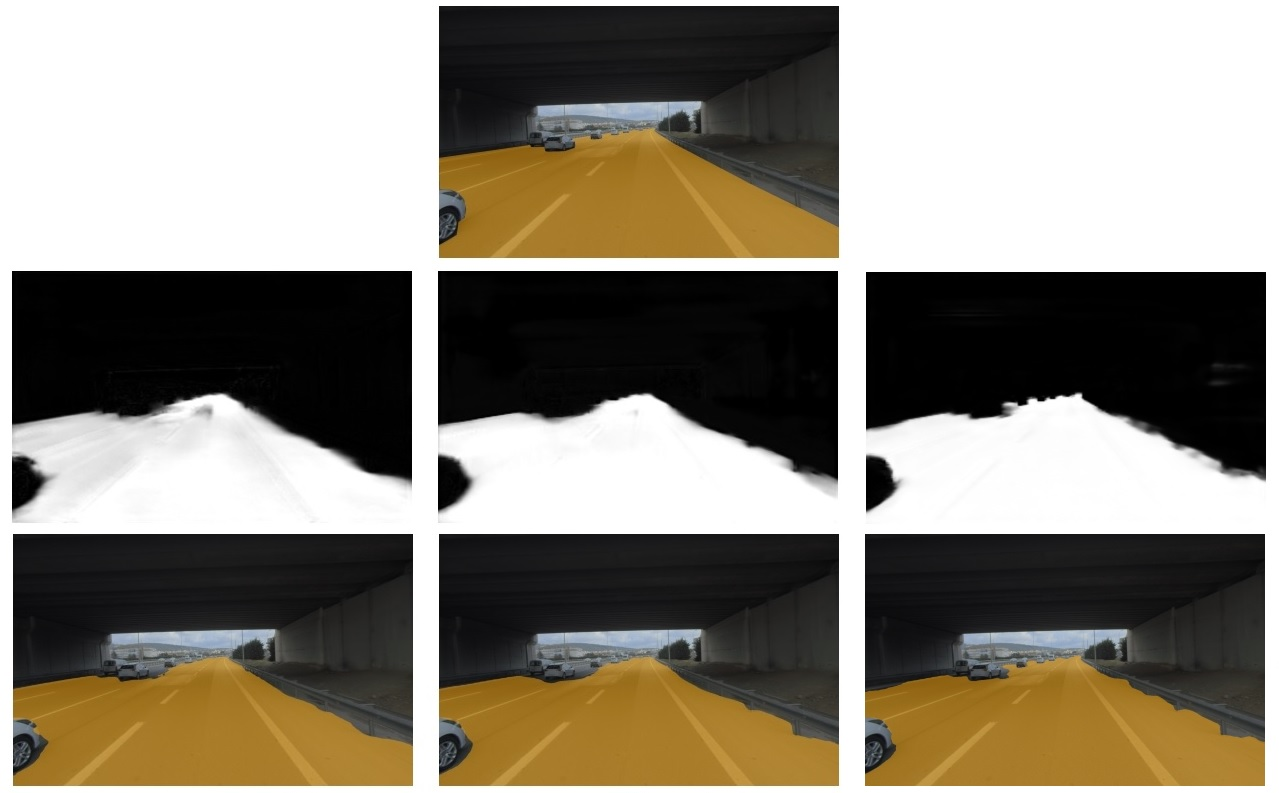

The model has done quite well around the vehicle at close range and still has trouble determining the boundaries of the road. In general, it can be seen that the prediction of the model is starting to become definite. The prediction of the model in the viaduct compared to other training has improved and made a prediction close to the ground truth.

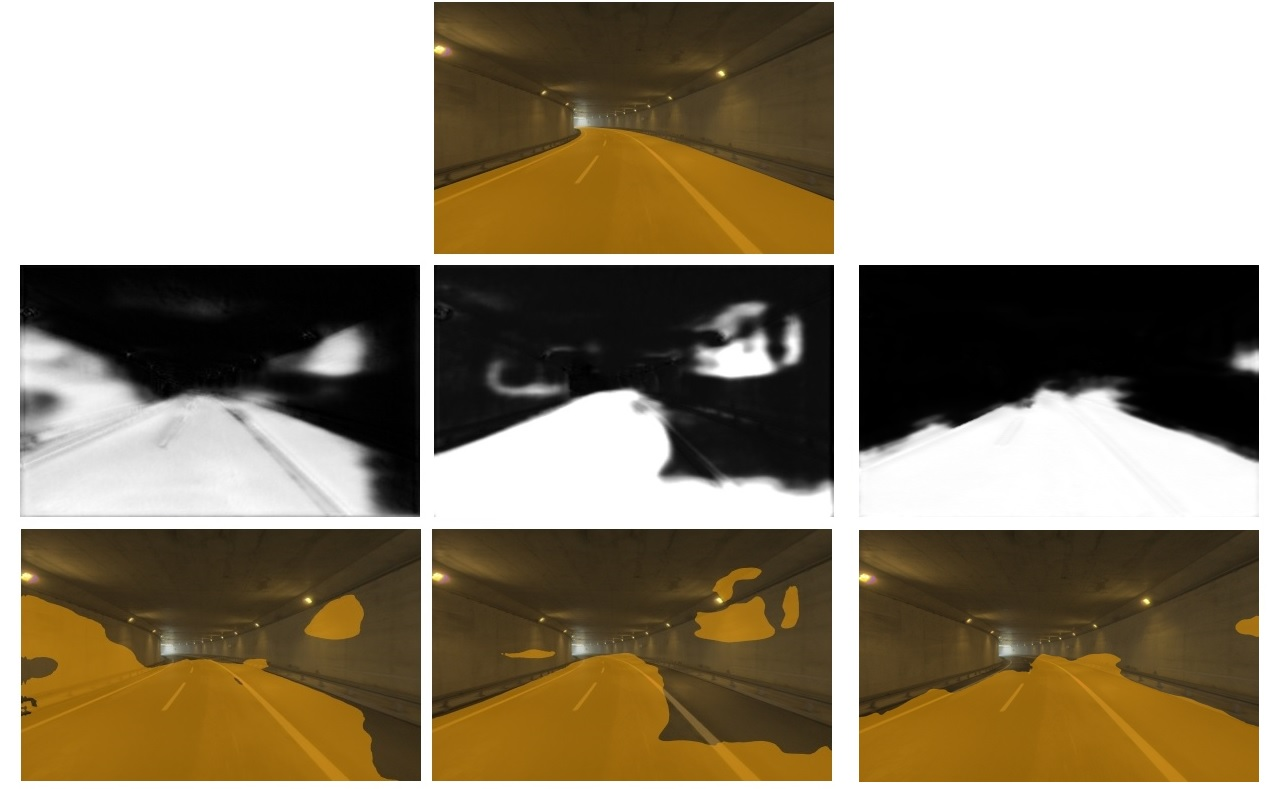

In tunnels, which is one of the situations where the model has difficulty in making a decision, it is seen that the freespace selected on the walls of the tunnel after augmentation decreases, and the freespace selected on the road increases. It is seen that augmentation improves the model's predictions in tunnels.

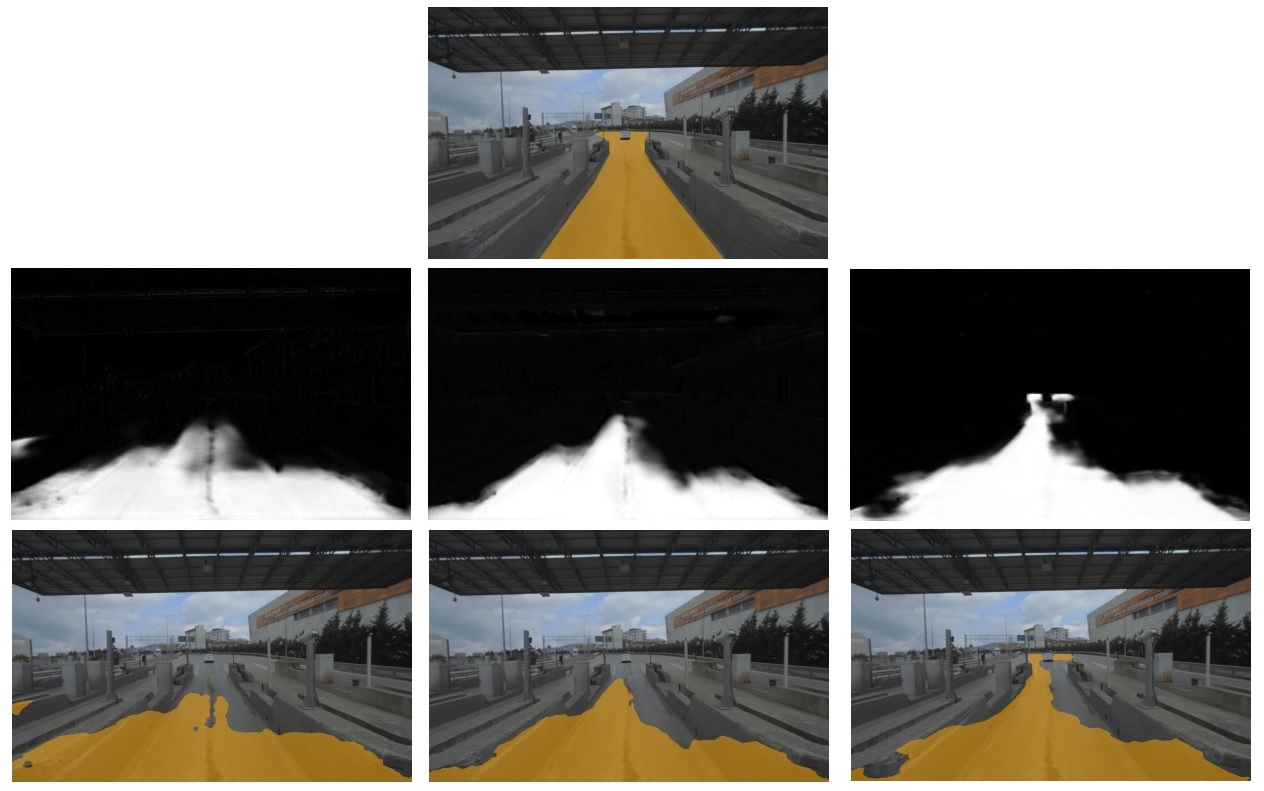

The model still makes similar predictions about the concrete barriers in the counter. The benefit of augmentation is that it increases the freespace parts on the road. Applying more complex augmentation can reduce freespace prediction in concrete barriers.

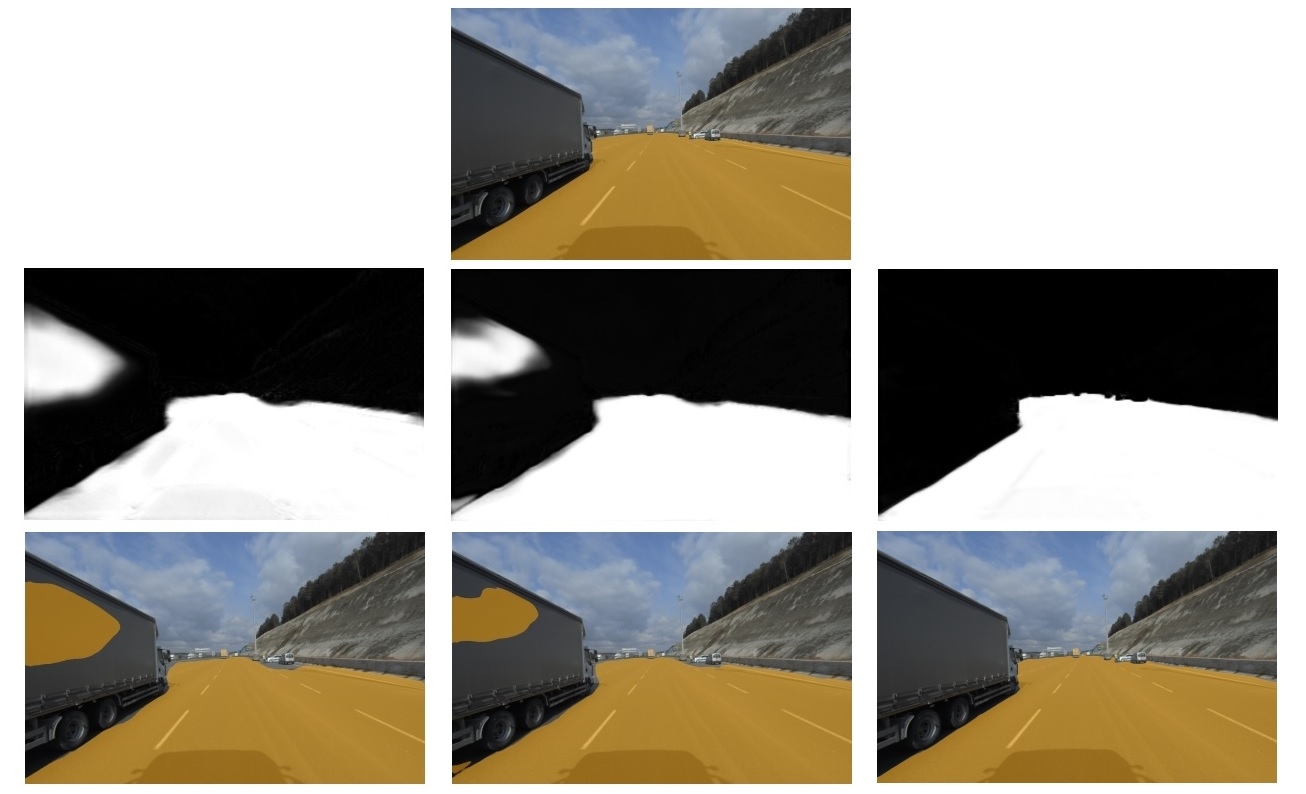

After augmentation, the model does not choose the truck as freespace and predicted a result very close to ground truht.The model's progress looks good in here.

After comparisons, it seems that augmentation increases the accuracy of the model's predictions, bringing it closer to the ground truth. As the process applied during augmentation becomes more complex, the accuracy rate will increase.

<br>
<br>

## Line Segmentation

### Solid Line

Firstly started with Solid Line Detection. The whole process is the same as in the freespace section. Only the code in the JSON to mask section has been changed as follows:

In [ ]:
class_name=obj['classTitle'] #solid line required
        if class_name == "Solid Line" :
            p=obj['points']          
            solidline_points=p['exterior'] #solid line's points x,y type

Once points are found line or lines(It may differ according to JSON) must be drawn to the empty mask with the following code:

In [ ]:
mask=cv2.cv2.polylines(mask,np.array([solidline_points]),False,1,thickness=10)

<b>Variables in order to:</b>mask(empty), points of solid lines, open or closed lines preference, the color of lines, and width of lines.The choice of open or closed means whether a line will be drawn between the start and endpoints of the line.

After masks created ground truth can be checkable with the mask on image function.

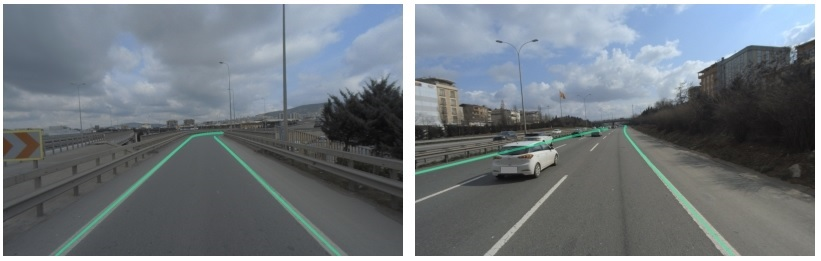

A comparison was made on graphs to measure the performance of the model. Started with 10 epochs on the left side. In the middle 10 epoch with dropout and finally 16 epoch with dropout at right.

<b>Dropout:</b> Used to prevent overfitting in the model. The dropout technique disables some nodes in the layer and leaves active the others.

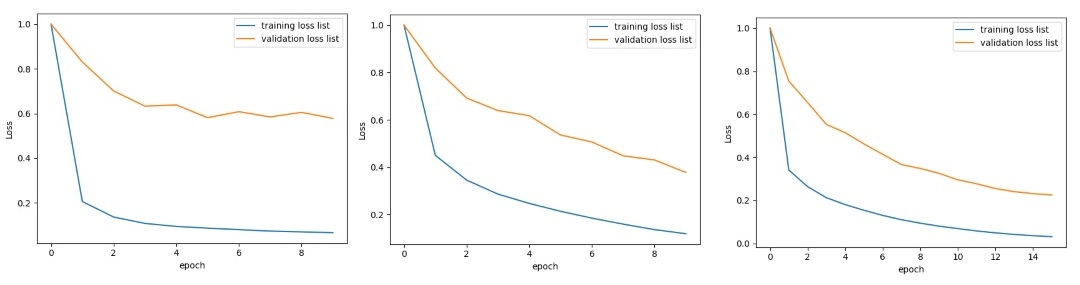

As can be seen from the left graph, the validation loss is quite high. After this result, dropout seems like a good option to reduce validation loss. Dropout and increase in the epoch number decreased the validation loss likely the other one.
Dropout implemented the model with nn.Dropout(p=0.5) function.

After increasing the number of epochs to 15, the model's predictions were compared with ground truth.

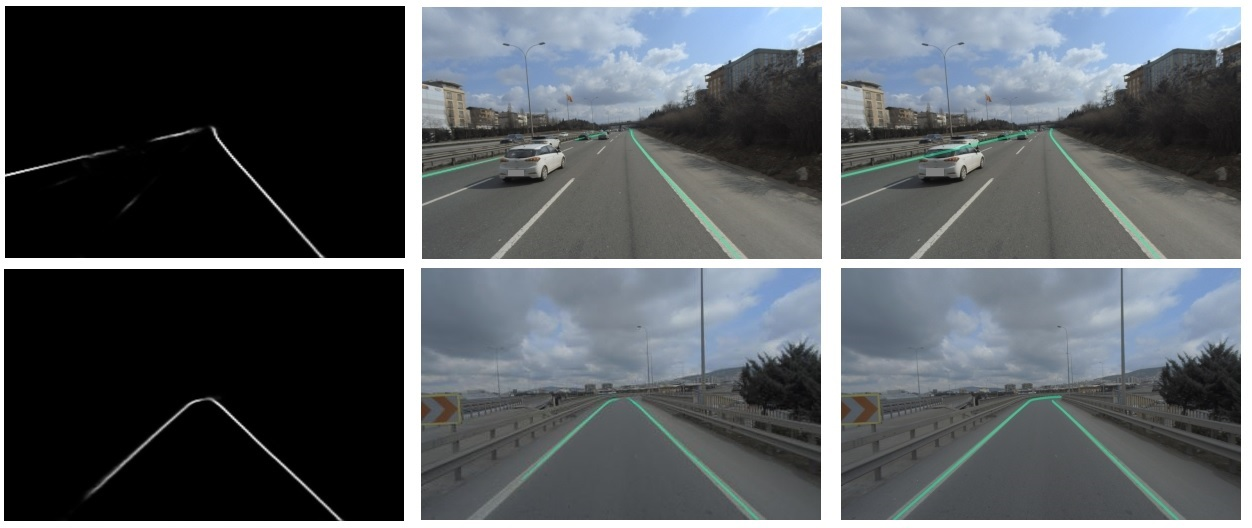

The above picture contains model prediction with 15 epoch and dropout, model prediction on the image, and the ground truth, respectively.
<br>
The model was also successful in the line with less confusion, but there are deficiencies in the prediction on the side where there are many vehicles and the line does not appear from time to time.
<br>
On the other, the model's prediction very successfully on one line in close range, but made a mistake at the beginning of the other line.
<br>
From these comparisons, it is clear that the model still needs training.

Although the model made predictions in open areas with good light, it was not successful in the presence of counter, tunnel, and trucks. The following picture shows model prediction, prediction on the image, and ground truth, respectively.

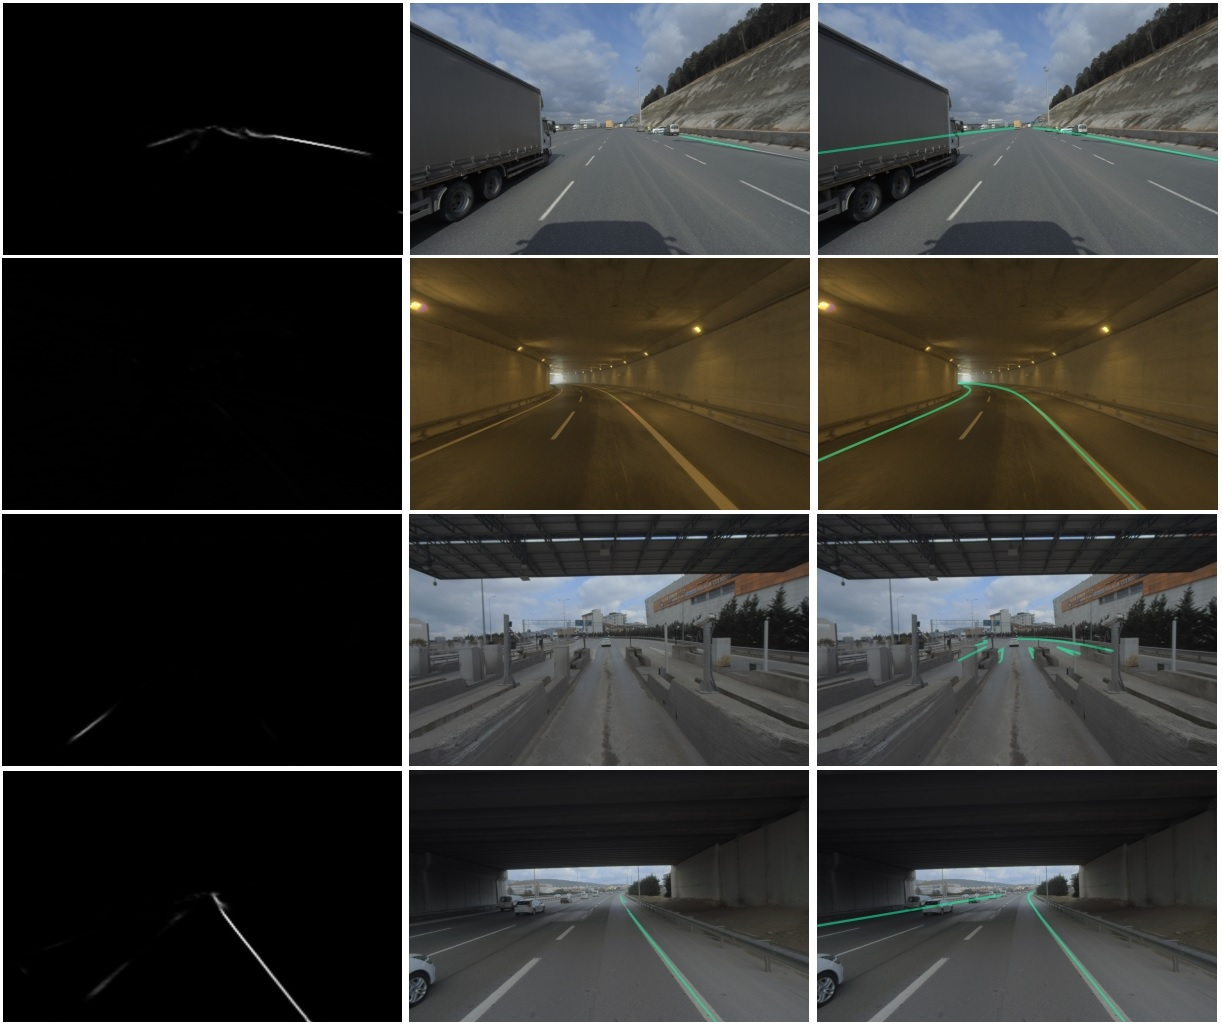

As can be understood from here, it is necessary to increase the training time of the model and to increase its training in different situations by applying augmentation to the dataset.

<br>
<br>

### Dashed Line

As mentioned before, all operation is the same as the others. The part to be changed is the class name searched in JSON in the JSON to mask section. Code and ground truth of image in the below.

In [ ]:
class_name=obj['classTitle'] #dashed line required
        if class_name == "Dashed Line" :
            p=obj['points']          
            dashedline_points=p['exterior'] #dashed line's points x,y type

Used the same code as on the solid line part for the draw mask.

In [ ]:
mask=cv2.cv2.polylines(mask,np.array([dashedline_points]),False,1,thickness=10)

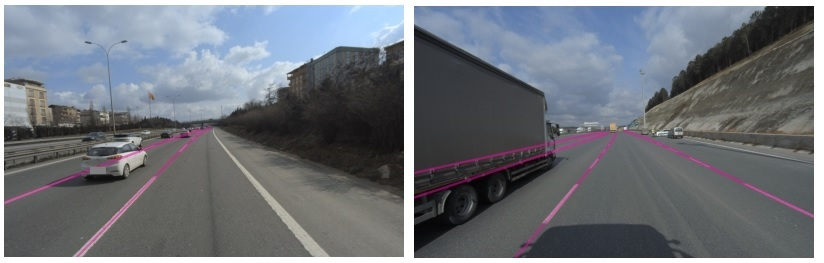

Below is the performance of the model in epoch 10 and epoch 20 without dropout. In the second row, the performance of the model in epoch 10 and epoch 15 after applying p = 0.5 dropout.

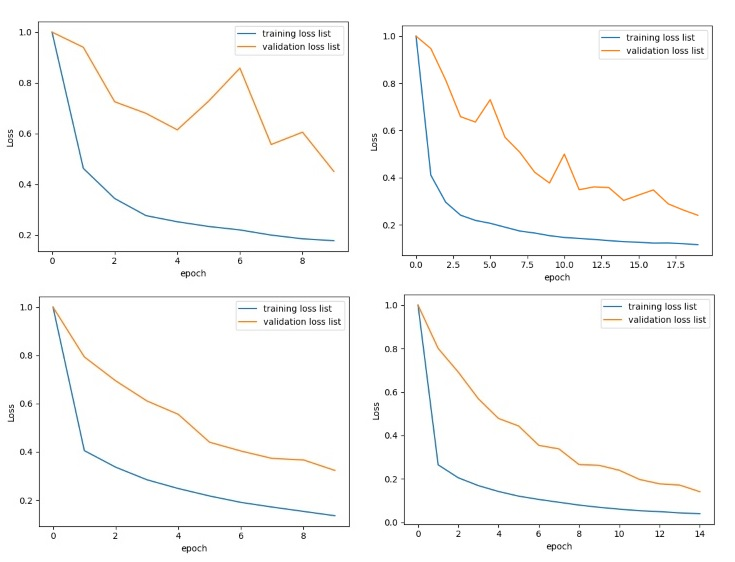

Epoch could not be increased to 20 because of GPU out of memory error while implementing dropout. As can see the graphs, implementing dropout reduces the sudden increases at the validation loss.
<br>
When applying the prediction of the model on the pictures, the model trained with 20 epoch was used, as it was seen that 15 epoch did not produce sufficient results. Training the model with 20 or more dropouts may give better results.

The results of the model trained with 20 epochs are below. Left to the right contains a model prediction, model prediction on the image, and ground truth.

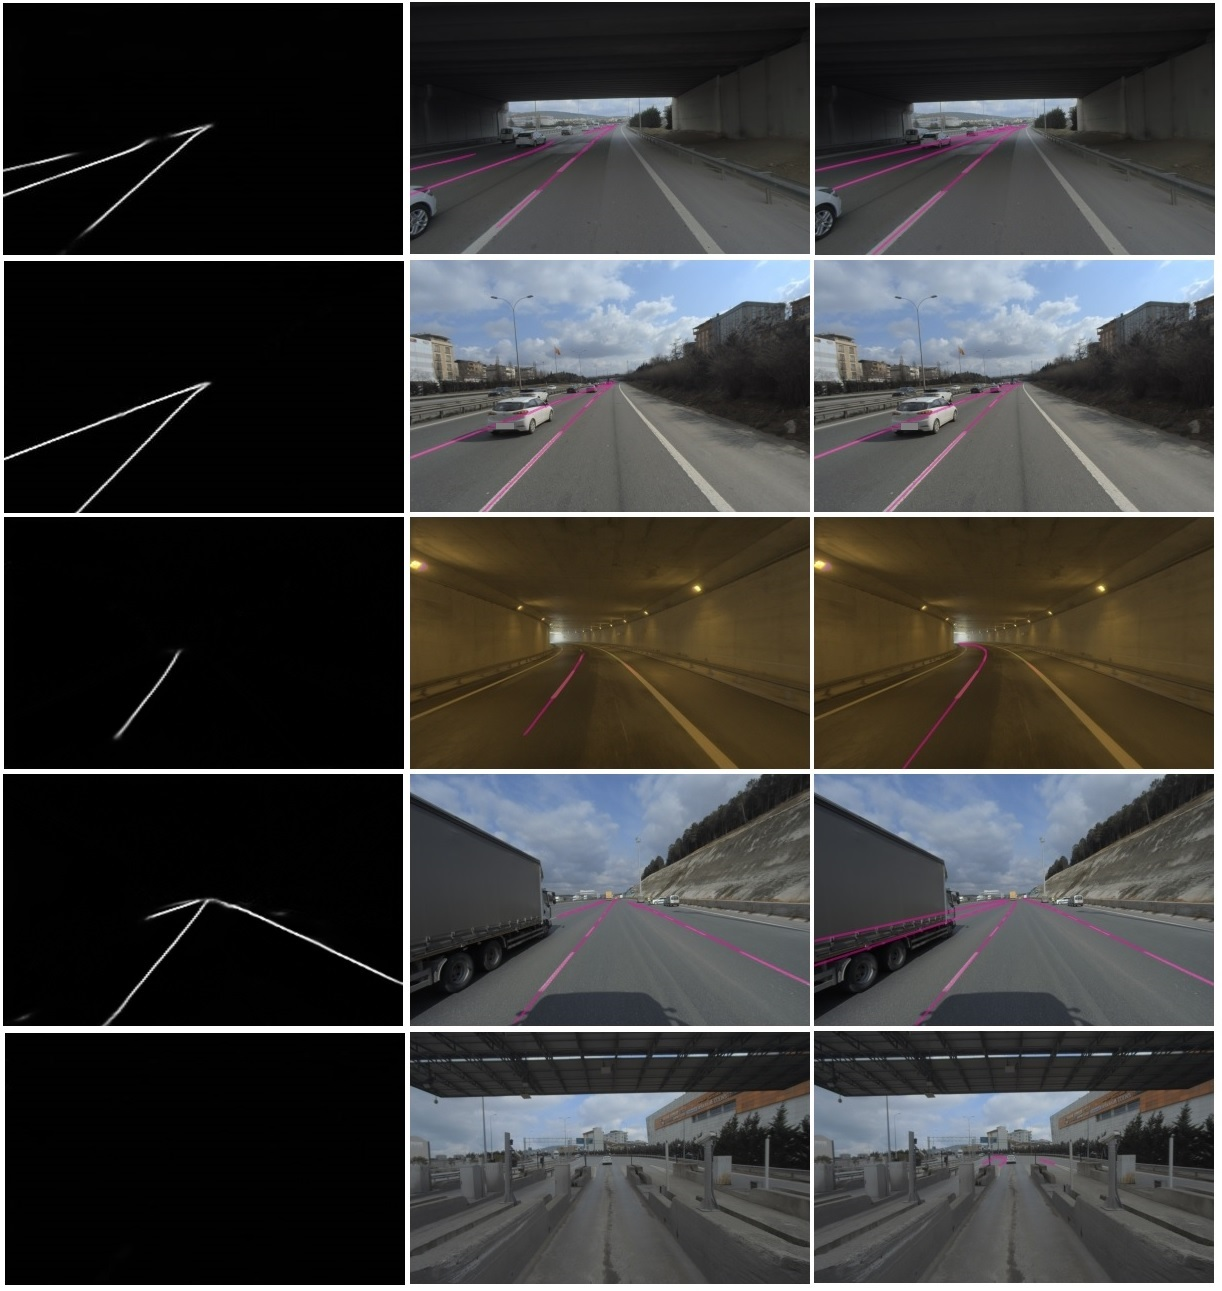

As in freespace and solid line, it is seen that the model has difficulties in predictions in situations that are not often encountered here. Applying augmentation as in freespace segmentation will increase the accuracy of the model's predictions on the solid lines.

## References

Main Reference:https://github.com/cakirogluozan/fo-intern-project
<br>
UNet Model:https://github.com/usuyama/pytorch-unet only function names changed,dropout implemented after second Conv layer in Sequential.
<br>
[1]https://deepai.org/machine-learning-glossary-and-terms/relu
<br>
[2]https://towardsdatascience.com/activation-functions-neural-networks-1cbd9f8d91d6
<br>
[3]https://gisgeography.com/bilinear-interpolation-resampling/
<br>
[4]https://towardsdatascience.com/everything-you-need-to-know-about-activation-functions-in-deep-learning-models-84ba9f82c253
<br>
[5]https://arxiv.org/abs/1505.04597 UNet Paper
<br>
[6]https://pytorch.org/docs/stable/generated/torch.cat.html
<br>
[7]https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
